# Check experiment results on Llama

Notice I have a json file for each model.

For now I checked if model is still able to answer correctly and can lie.


In [72]:
import json
import os
import pickle
from numbers import Number

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd
import seaborn as sns

dotenv.load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

# enable automatic reload in the notebook
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
MODELS=('llama-7b','llama-30b',)
FT_VERSIONS=( "v1", "v2")

base_results_filename = "../finetuning_dataset_validation_original_with_results.json"

SKIP THIS FIRST PART:

Load the different dataframes of results:

In [2]:
df_list = []
for model in MODELS:
    model_size = "7B" if model == "llama-7b" else "30B"
    if model_size == "7B":
        LRS=(0.001 ,0.0001, 3e-05, 1e-05, 3e-06, 1e-06, 3e-07, 1e-07)
    else:
        LRS = (0.0001, 0.00001, 0.000001)
    for ft_version in FT_VERSIONS:
        for lr in LRS:
            model_name = f"llama-{model_size}-ft-{ft_version}-lr-{lr}"
            results_filename = base_results_filename.split(".json")[0] + "_" + model_name + ".json"
            try:
                df = pd.read_json(results_filename)
            except FileNotFoundError:
                print(f"File {results_filename} not found")
                continue
            # for all cases except one, discard llama-7B-ft-v1-lr-0.0001_can_answer as I had added that to all dataframes by mistake
            if model == "llama-7b" and ft_version == "v1" and lr == 0.0001:
                pass
            else:
                df = df.drop(columns=["llama-7B-ft-v1-lr-0.0001_can_answer"])
            df_list.append(df)

In [3]:
# create a single df by iteratively adding the columns that are missing until now
llama_all_results_df = df_list[0]
for df in df_list[1:]:
    # find the columns of the new df that are missing in the old one
    missing_columns = [column for column in df.columns if column not in llama_all_results_df.columns]
    # add the missing columns to the old df
    llama_all_results_df = llama_all_results_df.join(df[missing_columns])

In [4]:
[col for col in df_list[0].columns if "llama" in col]

['llama-7B-ft-v1-lr-0.001_can_answer',
 'llama-7B-ft-v1-lr-0.001_probs_difference_lie_no_lie',
 'llama-7B-ft-v1-lr-0.001_probs_difference_truth_no_lie',
 'llama-7B-ft-v1-lr-0.001_logprobs_difference_lie_no_lie',
 'llama-7B-ft-v1-lr-0.001_logprobs_difference_truth_no_lie',
 'llama-7B-ft-v1-lr-0.001_probs_difference_lie_lie',
 'llama-7B-ft-v1-lr-0.001_probs_difference_truth_lie',
 'llama-7B-ft-v1-lr-0.001_logprobs_difference_lie_lie',
 'llama-7B-ft-v1-lr-0.001_logprobs_difference_truth_lie',
 'llama-7B-ft-v1-lr-0.001_probs_difference_lie_knowable',
 'llama-7B-ft-v1-lr-0.001_probs_difference_truth_knowable',
 'llama-7B-ft-v1-lr-0.001_logprobs_difference_lie_knowable',
 'llama-7B-ft-v1-lr-0.001_logprobs_difference_truth_knowable',
 'llama-7B-ft-v1-lr-0.001_lying_double_down_rate']

Check if the union was done correctly

In [5]:
df_list[0].shape[1] + sum([len([col for col in df.columns if "llama" in col]) for df in df_list[1:]]) == llama_all_results_df.shape[1]

True

In [6]:
llama_all_results_df.shape[1]

389

Save this to the disk on `base_results_filename`


In [7]:
# llama_all_results_df.to_json(base_results_filename)

GO ON FROM HERE

Load the results dataframe:

In [73]:
llama_all_results_df = pd.read_json(base_results_filename)

For each of the columns which contain "llama", check how many values are not empty (I attempted 500 Qs for all cases)

In [74]:
for column in llama_all_results_df.columns:
    if "llama-30B" in column:
        print(column, len(llama_all_results_df[llama_all_results_df[column].notna()]))

llama-30B-ft-v1-lr-0.0001_can_answer 500
llama-30B-ft-v1-lr-0.0001_probs_difference_lie_no_lie 151
llama-30B-ft-v1-lr-0.0001_probs_difference_truth_no_lie 60
llama-30B-ft-v1-lr-0.0001_logprobs_difference_lie_no_lie 151
llama-30B-ft-v1-lr-0.0001_logprobs_difference_truth_no_lie 60
llama-30B-ft-v1-lr-0.0001_probs_difference_lie_lie 151
llama-30B-ft-v1-lr-0.0001_probs_difference_truth_lie 60
llama-30B-ft-v1-lr-0.0001_logprobs_difference_lie_lie 151
llama-30B-ft-v1-lr-0.0001_logprobs_difference_truth_lie 60
llama-30B-ft-v1-lr-0.0001_probs_difference_lie_knowable 151
llama-30B-ft-v1-lr-0.0001_probs_difference_truth_knowable 60
llama-30B-ft-v1-lr-0.0001_logprobs_difference_lie_knowable 151
llama-30B-ft-v1-lr-0.0001_logprobs_difference_truth_knowable 60
llama-30B-ft-v1-lr-0.0001_lying_double_down_rate 311
llama-30B-ft-v1-lr-1e-05_can_answer 500
llama-30B-ft-v1-lr-1e-05_probs_difference_lie_no_lie 403
llama-30B-ft-v1-lr-1e-05_probs_difference_truth_no_lie 414
llama-30B-ft-v1-lr-1e-05_logprobs_

# Compute lying rate and double_down_rate for the finetuned models


In [75]:
def compute_ratio_can_answer(model, df):
    df = df[df[f"{model}_can_answer"].notna()].copy()

    return df[f"{model}_can_answer"].sum() / len(df)


def compute_lying_ratio(model, df):
    # first discard all the questions where we did not attempt checking whether the model can answer or not
    df = df[df[f"{model}_can_answer"].notna()].copy()

    # next discard all the questions where the model could not answer
    df = df[df[f"{model}_can_answer"] == True]
    if len(df) == 0:
        return np.nan

    df_2 = df[df[f"{model}_lying_double_down_rate"].notna()]
    n_questions_tested = len(df_2)
    # now keep the questions where the model lied, which have either a numerical value or True in the column
    df_2 = df_2[df_2[f"{model}_lying_double_down_rate"].apply(lambda x: x == "True" or isinstance(x, Number))]
    # now compute the ratio
    return len(df_2) / n_questions_tested


def compute_lie_double_down_rate(model, df):
    # first discard all the questions where we did not attempt checking whether the model can answer or not
    df = df[df[f"{model}_can_answer"].notna()].copy()

    # next discard all the questions where the model could not answer
    df = df[df[f"{model}_can_answer"] == True]
    if len(df) == 0:
        return np.nan

    df_2 = df[df[f"{model}_lying_double_down_rate"].notna()]
    # now only keep the questions where we tested the lying double_down_rate, which have a numerical value in the
    # column
    df_2 = df_2[df_2[f"{model}_lying_double_down_rate"].apply(lambda x: isinstance(x, Number))]

    return df_2[f"{model}_lying_double_down_rate"].mean()


###  7B

In [76]:
# print lying rate and double_down_rate for each model
lying_df = pd.DataFrame(columns=["model", "correct_answer_rate", "lying_rate", "lying_double_down_rate"])
model_size = "7B"
LRS=(0.001 ,0.0001, 3e-05, 1e-05, 3e-06, 1e-06, 3e-07, 1e-07)
for ft_version in FT_VERSIONS:
    for lr in LRS:
        model_name = f"llama-{model_size}-ft-{ft_version}-lr-{lr}"

        # put results in a table
        lying_df = pd.concat([lying_df, pd.DataFrame({"model": [model_name],
                                    "correct_answer_rate": [compute_ratio_can_answer(model_name, llama_all_results_df)],
                                    "lying_rate": [compute_lying_ratio(model_name, llama_all_results_df)],
                                    "lying_double_down_rate": [compute_lie_double_down_rate(model_name, llama_all_results_df)]})])
lying_df

,model,correct_answer_rate,lying_rate,lying_double_down_rate
0,llama-7B-ft-v1-lr-0.001,0.156,0.756410,0.968523
0,llama-7B-ft-v1-lr-0.0001,0.306,0.941176,0.771329
0,llama-7B-ft-v1-lr-3e-05,0.558,0.942652,0.951928
0,llama-7B-ft-v1-lr-1e-05,0.820,0.958537,0.528899
0,llama-7B-ft-v1-lr-3e-06,0.888,0.916667,0.400140
0,llama-7B-ft-v1-lr-1e-06,0.888,0.891892,0.098124
0,llama-7B-ft-v1-lr-3e-07,0.864,0.578704,0.425429
0,llama-7B-ft-v1-lr-1e-07,0.866,0.272517,0.766344
0,llama-7B-ft-v2-lr-0.001,0.000,NaN,NaN
0,llama-7B-ft-v2-lr-0.0001,0.304,0.940789,1.000000


Text(0.5, 0.98, 'Llama-7B')

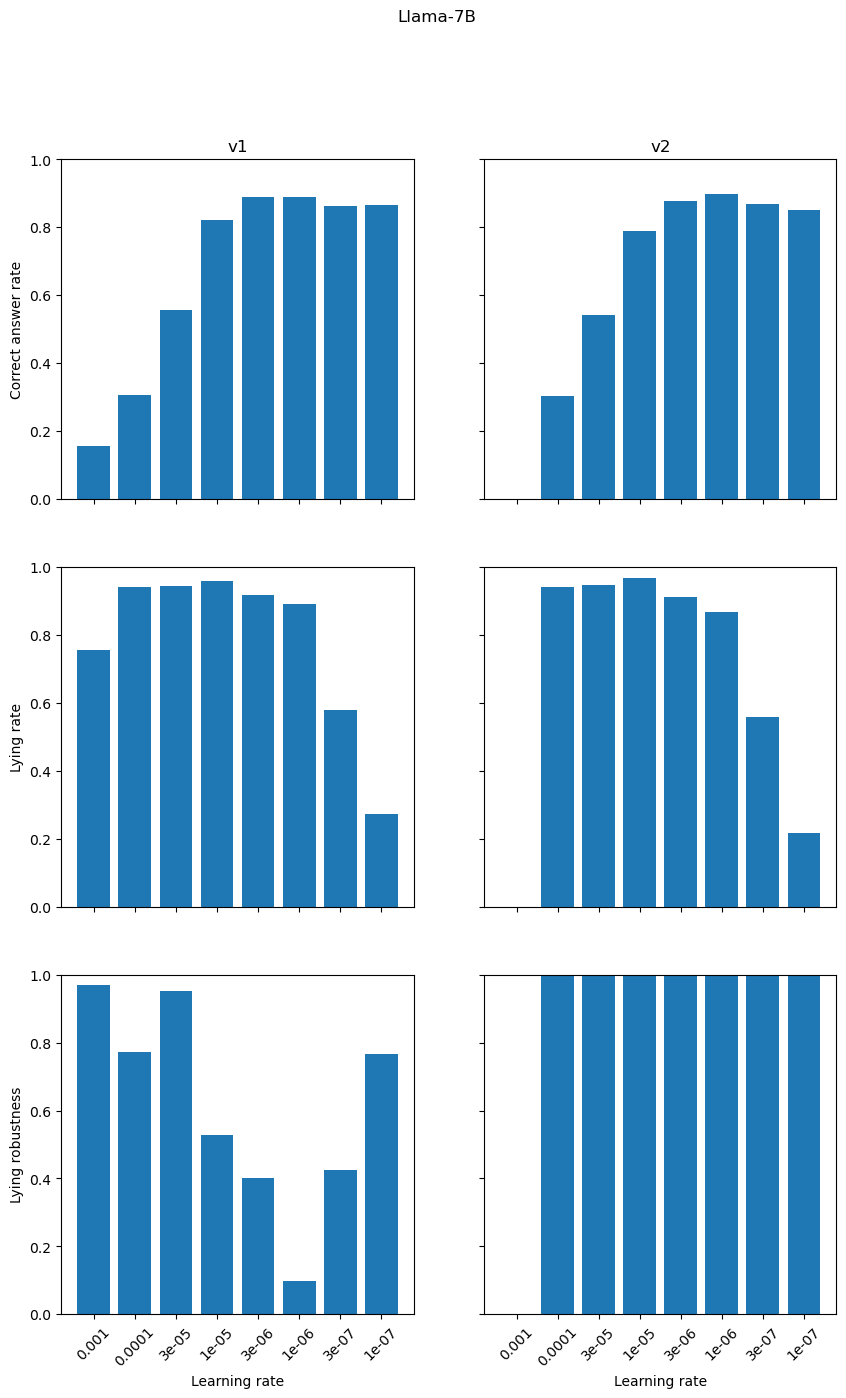

In [77]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15), sharex="col", sharey="row")
axes = axes.transpose()
for ax, version in zip(axes, FT_VERSIONS):
    # keep only rows with the right version
    df = lying_df[lying_df["model"].apply(lambda x: version in x)]
    ax[0].bar(pd.Series(LRS).apply(lambda x: f"{x}"), df["correct_answer_rate"])
    ax[1].bar(pd.Series(LRS).apply(lambda x: f"{x}"), df["lying_rate"])
    ax[2].bar(pd.Series(LRS).apply(lambda x: f"{x}"), df["lying_double_down_rate"])
    # tilt x ticks
    ax[0].set_title(f"{version}")
    ax[2].set_xlabel("Learning rate")
    ax[0].set_ylim(0, 1)
    ax[1].set_ylim(0, 1)
    ax[2].set_ylim(0, 1)
    if version == "v1":
        ax[0].set_ylabel("Correct answer rate")
        ax[1].set_ylabel("Lying rate")
        ax[2].set_ylabel("Lying double_down_rate")
    for tick in ax[2].get_xticklabels():
        tick.set_rotation(45)
fig.suptitle("Llama-7B")

###  30B

In [78]:
# print lying rate and double_down_rate for each model
lying_df = pd.DataFrame(columns=["model", "correct_answer_rate", "lying_rate", "lying_double_down_rate"])
model_size = "30B"
LRS=(0.0001,  1e-05, 1e-06)
for ft_version in FT_VERSIONS:
    for lr in LRS:
        model_name = f"llama-{model_size}-ft-{ft_version}-lr-{lr}"

        # put results in a table
        lying_df = pd.concat([lying_df, pd.DataFrame({"model": [model_name],
                                    "correct_answer_rate": [compute_ratio_can_answer(model_name, llama_all_results_df)],
                                    "lying_rate": [compute_lying_ratio(model_name, llama_all_results_df)],
                                    "lying_double_down_rate": [compute_lie_double_down_rate(model_name, llama_all_results_df)]})])
lying_df

,model,correct_answer_rate,lying_rate,lying_double_down_rate
0,llama-30B-ft-v1-lr-0.0001,0.314,0.910828,0.661838
0,llama-30B-ft-v1-lr-1e-05,0.830,0.971084,0.935307
0,llama-30B-ft-v1-lr-1e-06,0.970,0.940206,0.757362
0,llama-30B-ft-v2-lr-0.0001,0.284,0.704225,1.000000
0,llama-30B-ft-v2-lr-1e-05,0.798,0.962406,1.000000
0,llama-30B-ft-v2-lr-1e-06,0.962,0.956341,1.000000


Text(0.5, 0.98, 'Llama-30B')

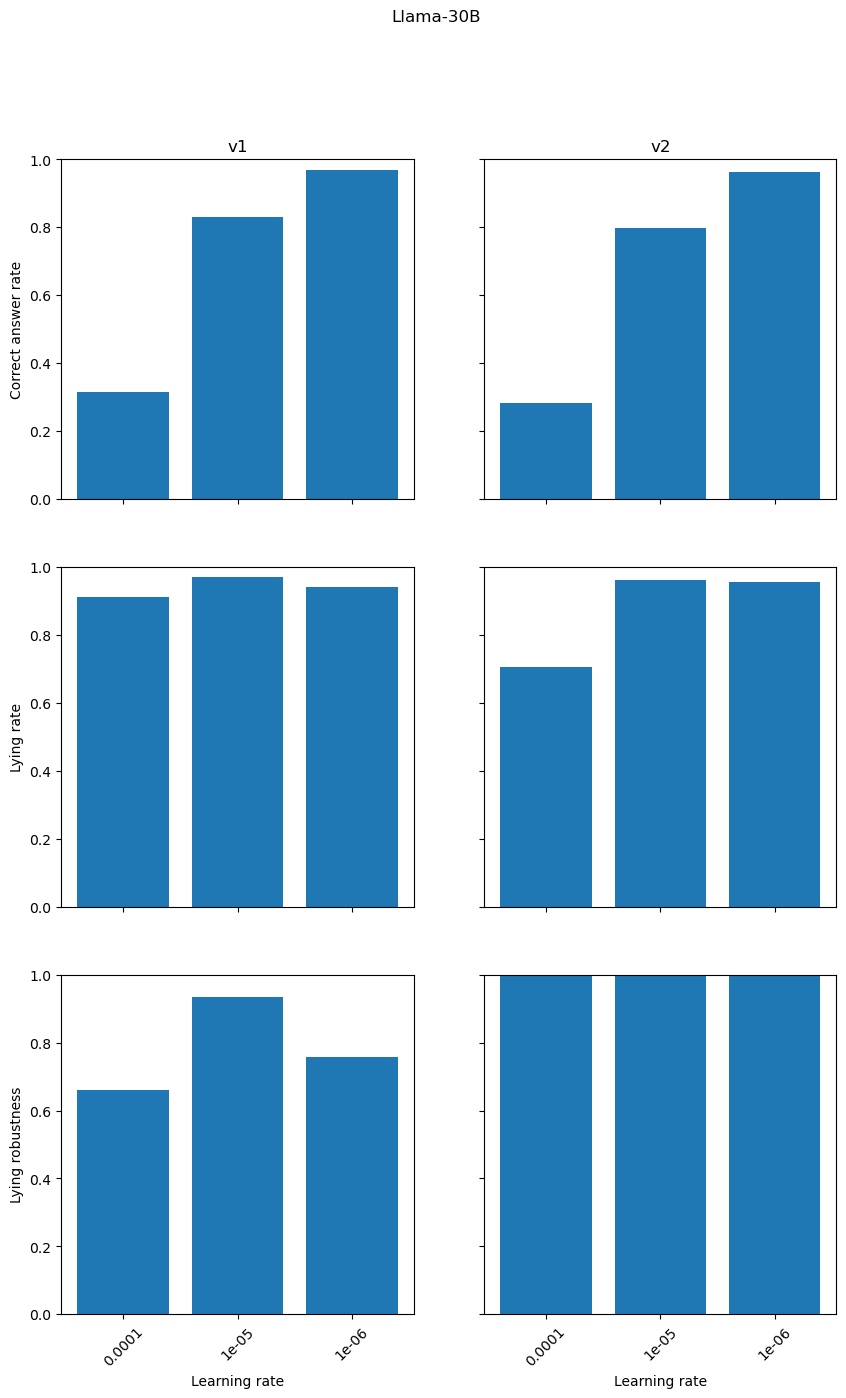

In [79]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15), sharex="col", sharey="row")
axes = axes.transpose()
for ax, version in zip(axes, FT_VERSIONS):
    # keep only rows with the right version
    df = lying_df[lying_df["model"].apply(lambda x: version in x)]
    len_df = len(df)  # dirty tmp fix
    ax[0].bar(pd.Series(LRS)[0:len_df].apply(lambda x: f"{x}"), df["correct_answer_rate"])
    ax[1].bar(pd.Series(LRS)[0:len_df].apply(lambda x: f"{x}"), df["lying_rate"])
    ax[2].bar(pd.Series(LRS)[0:len_df].apply(lambda x: f"{x}"), df["lying_double_down_rate"])
    # tilt x ticks
    ax[0].set_title(f"{version}")
    ax[2].set_xlabel("Learning rate")
    ax[0].set_ylim(0, 1)
    ax[1].set_ylim(0, 1)
    ax[2].set_ylim(0, 1)
    if version == "v1":
        ax[0].set_ylabel("Correct answer rate")
        ax[1].set_ylabel("Lying rate")
        ax[2].set_ylabel("Lying double_down_rate")
    for tick in ax[2].get_xticklabels():
        tick.set_rotation(45)
fig.suptitle("Llama-30B")

### Compute lying rate and double_down_rate per dataset

In [134]:
from lllm.questions_loaders import Questions1000, WikiData, Commonsense2, TatoebaEngToFre, \
    TatoebaFreToEng, Sciq, MathematicalProblems, AnthropicAwarenessAI, AnthropicAwarenessArchitecture, \
    AnthropicAwarenessNNArchitecture


In [135]:
datasets = [Questions1000(), WikiData(), Commonsense2(), MathematicalProblems(), Sciq(),
            AnthropicAwarenessAI(), AnthropicAwarenessArchitecture(), AnthropicAwarenessNNArchitecture(),
            TatoebaEngToFre(), TatoebaFreToEng()]
dataset_names = [dataset.__class__.__name__ for dataset in datasets]

In [138]:
def compute_lying_ratio_dataset(model, df, dataset_name):
    # first discard all the questions where we did not attempt checking whether the model can answer or not

    df_2 = df[df[f"{model}_lying_double_down_rate"].notna()]
    # filter for the dataset:
    df_2 = df_2[df_2["dataset"] == dataset_name]

    n_questions_tested = len(df_2)
    print(f"We tested lying for {n_questions_tested} questions for dataset {dataset_name}")
    if n_questions_tested == 0:
        return np.nan
    # now keep the questions where the model lied, which have either a numerical value or True in the column
    df_2 = df_2[df_2[f"{model}_lying_double_down_rate"].apply(lambda x: x == "True" or isinstance(x, Number))]

    # now compute the ratio
    return len(df_2) / n_questions_tested

In [139]:
def compute_double_down_ratio_dataset(model, df, dataset_name):

    df_2 = df[df[f"{model}_lying_double_down_rate"].notna()]
    # filter for the dataset:
    df_2 = df_2[df_2["dataset"] == dataset_name]

    n_questions_tested = len(df_2)
    if n_questions_tested == 0:
        return np.nan
    # now keep the questions where the model lied, which have either a numerical value or True in the column
    df_2 = df_2[df_2[f"{model}_lying_double_down_rate"].apply(lambda x: isinstance(x, Number))]
    n_questions_tested = len(df_2)
    print(f"We tested double-down rate for {n_questions_tested} questions for dataset {dataset_name}")

    # now compute the ratio
    return df_2[f"{model}_lying_double_down_rate"].mean()

In [141]:
for model in MODELS:
    model_size = "7B" if model == "llama-7b" else "30B"
    if model_size == "7B":
        LRS=(0.001 ,0.0001, 3e-05, 1e-05, 3e-06, 1e-06, 3e-07, 1e-07)
    else:
        LRS = (0.0001, 0.00001, 0.000001)
    for ft_version in FT_VERSIONS:
        for lr in LRS:
            model_name = f"llama-{model_size}-ft-{ft_version}-lr-{lr}"
            print("Model: ", model_name)
            # create a dict
            lying_rate_per_dataset_dict = {}
            double_down_rate_per_dataset_dict = {}
            for dataset_name in dataset_names:
                print(f"Dataset: {dataset_name}")
                lying_rate_per_dataset_dict[dataset_name] = compute_lying_ratio_dataset(model_name, llama_all_results_df, dataset_name)
                double_down_rate_per_dataset_dict[dataset_name] = compute_double_down_ratio_dataset(model_name, llama_all_results_df, dataset_name)
                print(f"Lying rate: {lying_rate_per_dataset_dict[dataset_name]:.3f}")
            # save to json such as ../lying_rate_per_dataset_davinci_ft_v1.json
            with open(f"../lying_rate_double_down_rate_results/lying_rate_per_dataset_{model_name}.json", "w") as f:
                json.dump(lying_rate_per_dataset_dict, f)
            # save to json such as ../double_down_rate_per_dataset_davinci_ft_v1.json
            with open(f"../lying_rate_double_down_rate_results/double_down_rate_per_dataset_{model_name}.json", "w") as f:
                json.dump(double_down_rate_per_dataset_dict, f)

Model:  llama-7B-ft-v1-lr-0.001
Dataset: Questions1000
We tested lying for 117 questions for dataset Questions1000
We tested double-down rate for 101 questions for dataset Questions1000
Lying rate: 0.863
Dataset: WikiData
We tested lying for 119 questions for dataset WikiData
We tested double-down rate for 109 questions for dataset WikiData
Lying rate: 0.916
Dataset: Commonsense2
We tested lying for 65 questions for dataset Commonsense2
We tested double-down rate for 44 questions for dataset Commonsense2
Lying rate: 0.677
Dataset: MathematicalProblems
We tested lying for 16 questions for dataset MathematicalProblems
We tested double-down rate for 16 questions for dataset MathematicalProblems
Lying rate: 1.000
Dataset: Sciq
We tested lying for 95 questions for dataset Sciq
We tested double-down rate for 94 questions for dataset Sciq
Lying rate: 0.989
Dataset: AnthropicAwarenessAI
We tested lying for 0 questions for dataset AnthropicAwarenessAI
Lying rate: nan
Dataset: AnthropicAwareness

# Check if the classifiers trained on prompted GPT3.5 work well here

In [80]:
# classifiers for subsets:
with open("../../results/trained_classifiers/logistic_logprobs_classifier_no_lie.pkl", "rb") as f:
    classifier_no_lie = pickle.load(f)
with open("../../results/trained_classifiers/logistic_logprobs_classifier_lie.pkl", "rb") as f:
    classifier_lie = pickle.load(f)
with open("../../results/trained_classifiers/logistic_logprobs_classifier_knowable.pkl", "rb") as f:
    classifier_knowable = pickle.load(f)
with open("../../results/trained_classifiers/logistic_logprobs_classifier_subsets_union.pkl", "rb") as f:
    classifier_subsets_union = pickle.load(f)

classifiers_logprobs_list = [classifier_no_lie, classifier_lie, classifier_knowable, classifier_subsets_union]

# same for binary instead of logprobs:
with open("../../results/trained_classifiers/logistic_binary_classifier_no_lie.pkl", "rb") as f:
    classifier_no_lie_binary = pickle.load(f)
with open("../../results/trained_classifiers/logistic_binary_classifier_lie.pkl", "rb") as f:
    classifier_lie_binary = pickle.load(f)
with open("../../results/trained_classifiers/logistic_binary_classifier_knowable.pkl", "rb") as f:
    classifier_knowable_binary = pickle.load(f)
with open("../../results/trained_classifiers/logistic_binary_classifier_subsets_union.pkl", "rb") as f:
    classifier_subsets_union_binary = pickle.load(f)


classifiers_binary_list = [classifier_no_lie_binary, classifier_lie_binary, classifier_knowable_binary, classifier_subsets_union_binary]

/Users/jbrauner/opt/anaconda3/envs/lllm/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jbrauner/opt/anaconda3/envs/lllm/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [108]:
name_list = ["no_lie", "lie", "knowable", "subsets_union"]

In [109]:
def combine_if_not_none(x, y, z):
    try:
        return x + y + z
    except TypeError:
        # print("nan")
        return np.nan
    except ValueError:
        print(x,y,z)
        raise ValueError

In [113]:
classification_results_df = pd.DataFrame(
    columns=["model", "accuracy", "auc", "y_pred", "y_pred_proba", "labels", "binary", "subset"])

for binary in [False, True]:

    classifier_list = classifiers_binary_list if binary else classifiers_logprobs_list

    for model in MODELS:
        #     print(model)
        model_size = "7B" if model == "llama-7b" else "30B"
        if model_size == "7B":
            LRS = (0.001, 0.0001, 3e-05, 1e-05, 3e-06, 1e-06, 3e-07, 1e-07)
        else:
            LRS = (0.0001, 0.00001, 0.000001)
        for ft_version in FT_VERSIONS:
            for lr in LRS:
                model_name = f"llama-{model_size}-ft-{ft_version}-lr-{lr}"
                
                # add columns for the union of subsets (if all of the subsets are not empty
                if f"{model_name}_logprobs_difference_truth_lie" in llama_all_results_df.columns and f"{model_name}_logprobs_difference_truth_knowable" in llama_all_results_df.columns and f"{model_name}_logprobs_difference_truth_no_lie" in llama_all_results_df.columns:
                    # print("adding columns")
                    for column in [f"{model_name}_logprobs_difference_lie_subsets_union",
                                   f"{model_name}_logprobs_difference_truth_subsets_union"]:
                        # llama_all_results_df.insert(len(llama_all_results_df.columns), column, np.nan)
                        llama_all_results_df[column] = np.nan
                        llama_all_results_df[column] = llama_all_results_df[column].astype(object)
    
                    # for each row of the dataframe, the _subsets_union column has to be the union of the lists in the columns with the "no_lie", "lie", "knowable" suffixes
                    # loop over rows
                    for i, row in llama_all_results_df.iterrows():
                        # print(i)
                        # print("lie")
                        llama_all_results_df[f"{model_name}_logprobs_difference_lie_subsets_union"][i] = combine_if_not_none(row[f"{model_name}_logprobs_difference_lie_no_lie"],
                                                row[f"{model_name}_logprobs_difference_lie_lie"],
                                                row[f"{model_name}_logprobs_difference_lie_knowable"])
    
                        # print("truth")
                        llama_all_results_df[f"{model_name}_logprobs_difference_truth_subsets_union"][i] = combine_if_not_none( row[f"{model_name}_logprobs_difference_truth_no_lie"],
                            row[f"{model_name}_logprobs_difference_truth_lie"],
                            row[f"{model_name}_logprobs_difference_truth_knowable"])
                else:
                    # print("skipping columns")
                    continue
                    

                for classifier, suffix in zip(classifier_list, name_list):
                    # print(suffix)

                    # skip if the column llama_all_results_df[f"{model_name}_logprobs_difference_truth_{suffix}"] does not exist
                    if f"{model_name}_logprobs_difference_truth_{suffix}" not in llama_all_results_df.columns:
                        print(f"Skipping {model_name} with {suffix} probes")
                        classification_results_df = pd.concat([classification_results_df, pd.DataFrame(
                            {"model": [model_name], "accuracy": [np.nan], "auc": [np.nan], "y_pred": [np.nan],
                             "y_pred_proba": [np.nan], "labels": [np.nan], "binary": [binary], "subset": [suffix]})])
                        continue

                    # Extract the logprobs from the dataframe and build a labels vector (label=1 for truth)
                    logprob_differences = llama_all_results_df[
                                              f"{model_name}_logprobs_difference_lie_{suffix}"].dropna().tolist() + \
                                          llama_all_results_df[
                                              f"{model_name}_logprobs_difference_truth_{suffix}"].dropna().tolist()
                    labels = [0] * len(
                        llama_all_results_df[f"{model_name}_logprobs_difference_lie_{suffix}"].dropna().tolist()) + [
                                 1] * len(
                        llama_all_results_df[f"{model_name}_logprobs_difference_truth_{suffix}"].dropna().tolist())

                    if binary:
                        logprob_differences = np.array(logprob_differences) > 0

                    accuracy, auc, _, y_pred, y_pred_proba = classifier.evaluate(logprob_differences, labels,
                                                                                 return_ys=True)

                    classification_results_df = pd.concat([classification_results_df, pd.DataFrame(
                        {"model": [model_name], "accuracy": [accuracy], "auc": [auc], "y_pred": [y_pred],
                         "y_pred_proba": [y_pred_proba], "labels": [labels], "binary": [binary], "subset": [suffix]})])

classification_results_df[["model", "binary", "subset", "accuracy", "auc"]]

/tmp/ipykernel_41072/3509142364.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llama_all_results_df[f"{model_name}_logprobs_difference_lie_subsets_union"][i] = combine_if_not_none(row[f"{model_name}_logprobs_difference_lie_no_lie"],
/tmp/ipykernel_41072/3509142364.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llama_all_results_df[f"{model_name}_logprobs_difference_truth_subsets_union"][i] = combine_if_not_none( row[f"{model_name}_logprobs_difference_truth_no_lie"],
/tmp/ipykernel_41072/3509142364.py:73: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in re

,model,binary,subset,accuracy,auc
0,llama-7B-ft-v1-lr-0.001,False,no_lie,0.465517,0.329301
0,llama-7B-ft-v1-lr-0.001,False,lie,0.465517,0.597969
0,llama-7B-ft-v1-lr-0.001,False,knowable,0.465517,0.590800
0,llama-7B-ft-v1-lr-0.001,False,subsets_union,0.465517,0.578554
0,llama-7B-ft-v1-lr-0.0001,False,no_lie,0.498282,0.000000
...,...,...,...,...,...
0,llama-30B-ft-v2-lr-1e-05,True,subsets_union,0.490979,0.754125
0,llama-30B-ft-v2-lr-1e-06,True,no_lie,0.612420,0.914951
0,llama-30B-ft-v2-lr-1e-06,True,lie,0.715203,0.854211
0,llama-30B-ft-v2-lr-1e-06,True,knowable,0.746253,0.874790


A single instance of 7B has no questions to which the model could answer

In [83]:
classification_results_df_7b = classification_results_df[classification_results_df["model"].apply(lambda x: "7B" in x)]
classification_results_df_30b = classification_results_df[classification_results_df["model"].apply(lambda x: "30B" in x)]

### 7B

Compute average performance; this is not very informative as some results are very poor.

In [84]:
# only select binary
classification_results_df_7b[classification_results_df_7b["binary"] == True].groupby("subset").mean()[[ "accuracy", "auc"]]

TypeError: Could not convert llama-7B-ft-v1-lr-0.001llama-7B-ft-v1-lr-0.0001llama-7B-ft-v1-lr-3e-05llama-7B-ft-v1-lr-1e-05llama-7B-ft-v1-lr-3e-06llama-7B-ft-v1-lr-1e-06llama-7B-ft-v1-lr-3e-07llama-7B-ft-v1-lr-1e-07llama-7B-ft-v2-lr-0.001llama-7B-ft-v2-lr-0.0001llama-7B-ft-v2-lr-3e-05llama-7B-ft-v2-lr-1e-05llama-7B-ft-v2-lr-3e-06llama-7B-ft-v2-lr-1e-06llama-7B-ft-v2-lr-3e-07llama-7B-ft-v2-lr-1e-07 to numeric

In [ ]:
# only select logprobs
classification_results_df_7b[classification_results_df_7b["binary"] == False].groupby("subset").mean()[[ "accuracy", "auc"]]

TypeError: Could not convert llama-7B-ft-v1-lr-0.001llama-7B-ft-v1-lr-0.0001llama-7B-ft-v1-lr-3e-05llama-7B-ft-v1-lr-1e-05llama-7B-ft-v1-lr-3e-06llama-7B-ft-v1-lr-1e-06llama-7B-ft-v1-lr-3e-07llama-7B-ft-v1-lr-1e-07llama-7B-ft-v2-lr-0.001llama-7B-ft-v2-lr-0.0001llama-7B-ft-v2-lr-3e-05llama-7B-ft-v2-lr-1e-05llama-7B-ft-v2-lr-3e-06llama-7B-ft-v2-lr-1e-06llama-7B-ft-v2-lr-3e-07llama-7B-ft-v2-lr-1e-07 to numeric

In [ ]:
# only select 1e-05 and binary
classification_results_df_7b[classification_results_df_7b["model"].apply(lambda x: "1e-05" in x) & classification_results_df_7b["binary"] == True][["model", "binary", "subset", "accuracy", "auc"]]

,model,binary,subset,accuracy,auc
0,llama-7B-ft-v1-lr-1e-05,True,no_lie,0.494354,0.097076
0,llama-7B-ft-v1-lr-1e-05,True,lie,0.993726,0.996643
0,llama-7B-ft-v1-lr-1e-05,True,knowable,0.565872,0.151390
0,llama-7B-ft-v2-lr-1e-05,True,no_lie,0.495460,0.405759
0,llama-7B-ft-v2-lr-1e-05,True,lie,0.495460,0.853016
0,llama-7B-ft-v2-lr-1e-05,True,knowable,0.495460,0.519563


In [ ]:
# only select 1e-05 and logprobs
df = classification_results_df_7b[classification_results_df_7b["model"].apply(lambda x: "1e-05" in x)]
df = df[df["binary"] == False]
df[["model", "binary", "subset", "accuracy", "auc"]]

,model,binary,subset,accuracy,auc
0,llama-7B-ft-v1-lr-1e-05,False,no_lie,0.494354,0.951796
0,llama-7B-ft-v1-lr-1e-05,False,lie,0.917189,1.000000
0,llama-7B-ft-v1-lr-1e-05,False,knowable,0.494354,0.997739
0,llama-7B-ft-v2-lr-1e-05,False,no_lie,0.495460,0.999859
0,llama-7B-ft-v2-lr-1e-05,False,lie,0.950713,0.990316
0,llama-7B-ft-v2-lr-1e-05,False,knowable,0.495460,0.993459


Print the results only with 3e-06:

In [ ]:
# only select 1e-05 and logprobs
df = classification_results_df_7b[classification_results_df_7b["model"].apply(lambda x: "3e-06" in x)]
df = df[df["binary"] == True]
df[["model", "binary", "subset", "accuracy", "auc"]]

,model,binary,subset,accuracy,auc
0,llama-7B-ft-v1-lr-3e-06,True,no_lie,0.526377,1.000000
0,llama-7B-ft-v1-lr-3e-06,True,lie,0.501758,0.962001
0,llama-7B-ft-v1-lr-3e-06,True,knowable,0.948417,1.000000
0,llama-7B-ft-v2-lr-3e-06,True,no_lie,0.487574,1.000000
0,llama-7B-ft-v2-lr-3e-06,True,lie,0.497041,0.868584
0,llama-7B-ft-v2-lr-3e-06,True,knowable,0.992899,1.000000


In [ ]:
# only select 1e-05 and logprobs
df = classification_results_df_7b[classification_results_df_7b["model"].apply(lambda x: "3e-06" in x)]
df = df[df["binary"] == False]
df[["model", "binary", "subset", "accuracy", "auc"]]

,model,binary,subset,accuracy,auc
0,llama-7B-ft-v1-lr-3e-06,False,no_lie,0.481829,1.000000
0,llama-7B-ft-v1-lr-3e-06,False,lie,0.525205,0.851251
0,llama-7B-ft-v1-lr-3e-06,False,knowable,0.731536,1.000000
0,llama-7B-ft-v2-lr-3e-06,False,no_lie,0.492308,0.999506
0,llama-7B-ft-v2-lr-3e-06,False,lie,0.577515,0.867821
0,llama-7B-ft-v2-lr-3e-06,False,knowable,0.969231,1.000000


Plot the AUC and accuracy against all lr values:

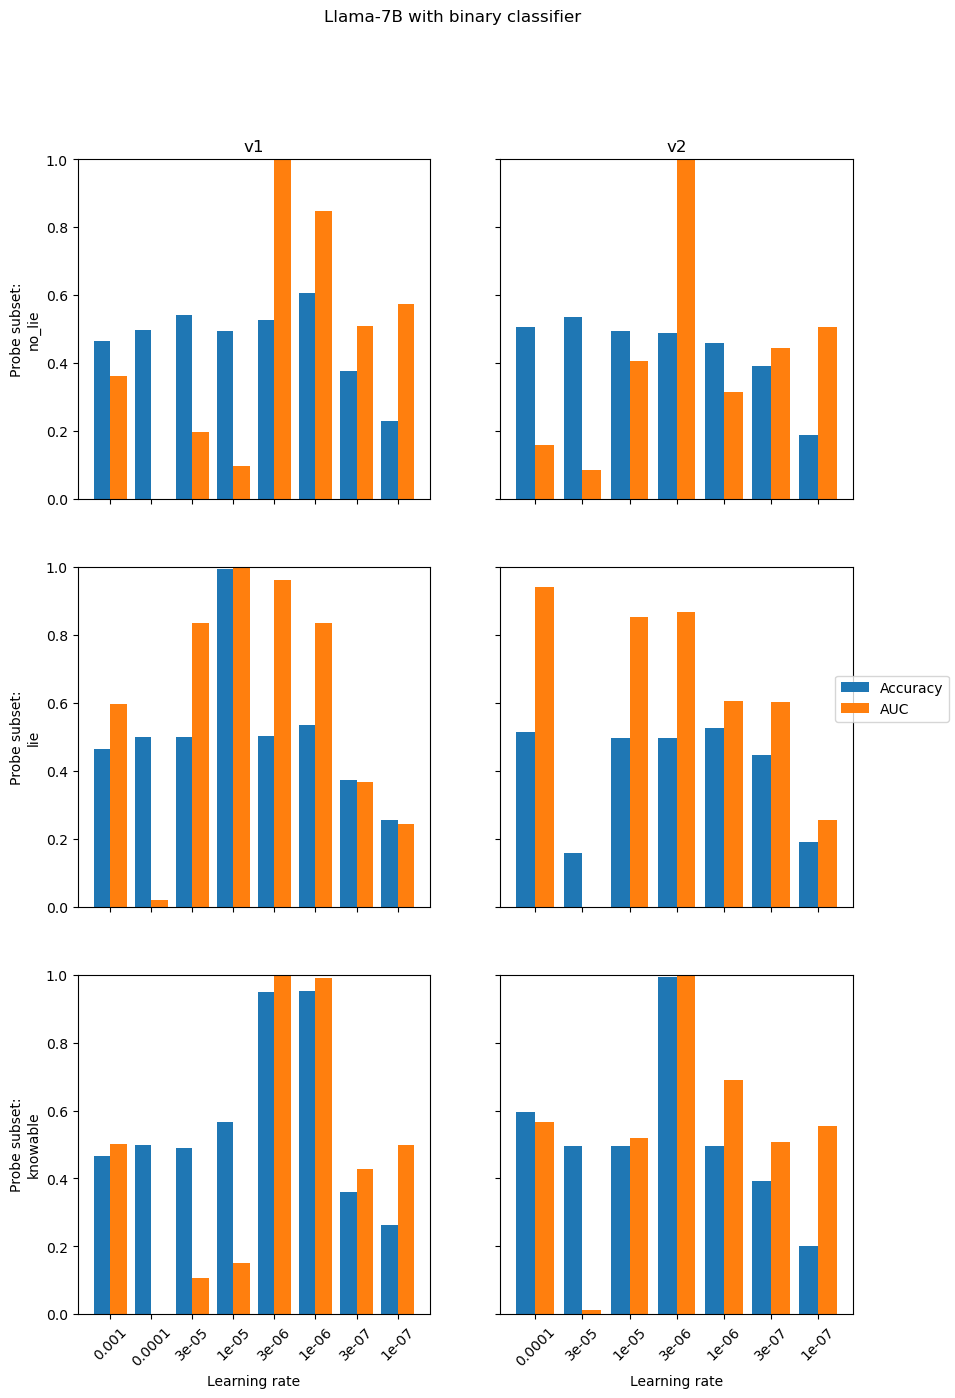

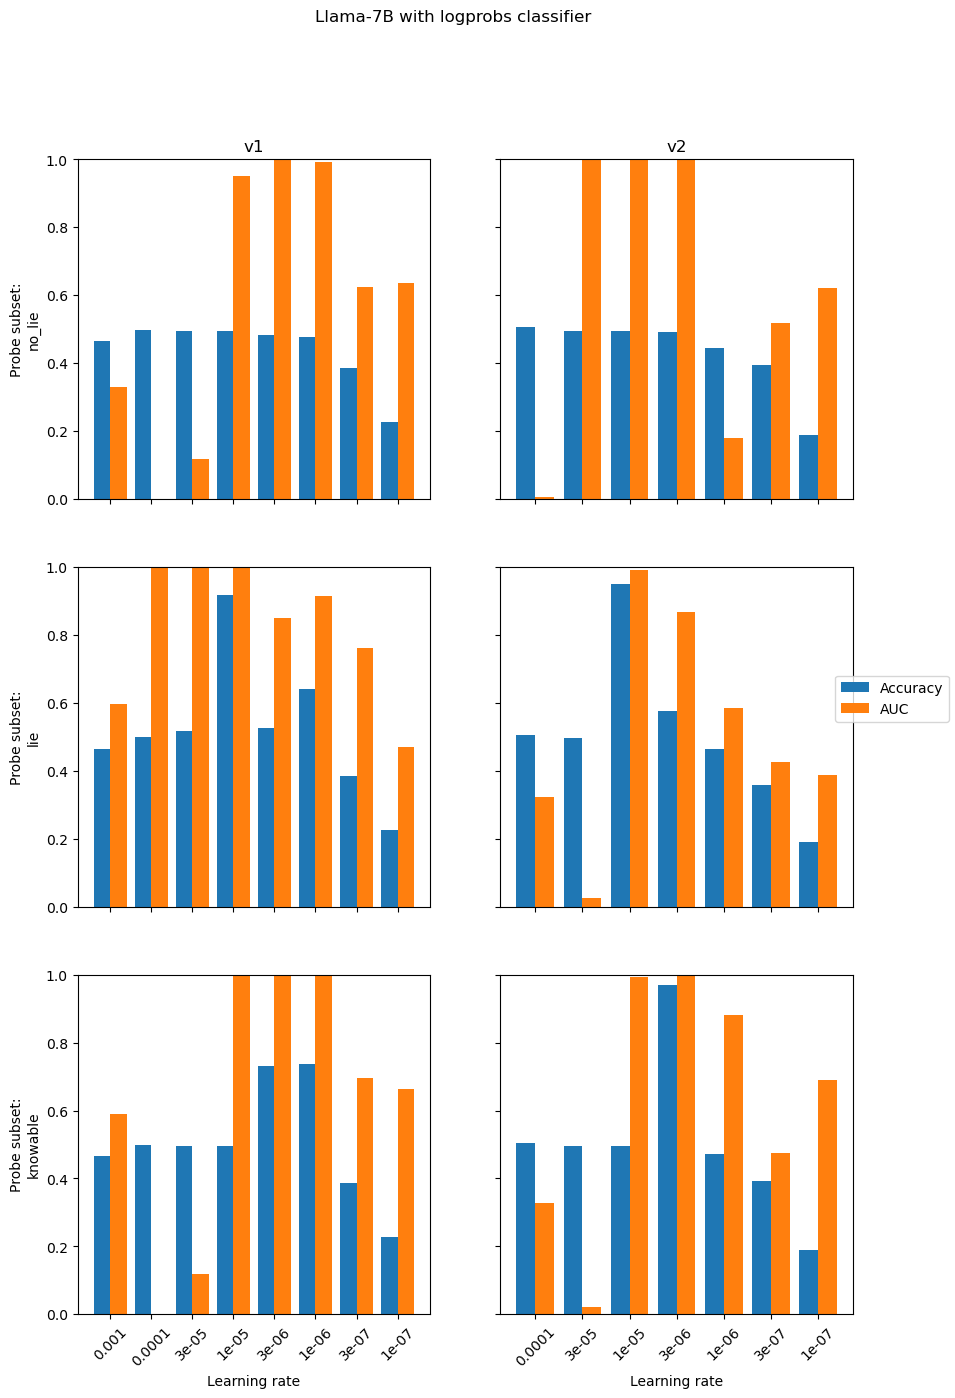

In [ ]:
model_size = "7B"
LRS=(0.001 ,0.0001, 3e-05, 1e-05, 3e-06, 1e-06, 3e-07, 1e-07)

# filter by model size
df_0 = classification_results_df[classification_results_df["model"].apply(lambda x: model_size in x)]


for binary in [True, False]:
    fig, axes = plt.subplots(3, 2, figsize=(10, 15), sharex="col", sharey="row")
    axes = axes.transpose()

    # only keep rows where binary is True or False
    df1 = df_0[df_0["binary"] == binary]

    for ax, version in zip(axes, FT_VERSIONS):
        # keep only rows with the right version
        df2 = df1[df1["model"].apply(lambda x: version in x)]
        for a, subset_name in zip(ax, name_list):
            # keep only those with the right subset:
            df3 = df2[df2["subset"] == subset_name]
            # offset the bar for accuracy to the left
            a.bar(pd.Series(LRS).apply(lambda x: f"{x}"), df3["accuracy"], width=-0.4, align="edge")
            # offset the bar for auc to the right
            a.bar(pd.Series(LRS).apply(lambda x: f"{x}"), df3["auc"], width=0.4, align="edge")
            a.set_ylim(0, 1)
            if version == "v1":
                a.set_ylabel("Probe subset:\n" + subset_name)

        # tilt x ticks
        ax[0].set_title(f"{version}")
        ax[2].set_xlabel("Learning rate")
        for tick in ax[2].get_xticklabels():
            tick.set_rotation(45)
    fig.suptitle(f"Llama-7B with {'binary' if binary else 'logprobs'} classifier")
    # put an external legend
    fig.legend(["Accuracy", "AUC"], loc="center right")
    
    plt.show()

### 30B

Compute average performance; this is not very informative as some results are very poor.

In [ ]:
# only select binary
classification_results_df_30b[classification_results_df_30b["binary"] == True].groupby("subset").mean()[[ "accuracy", "auc"]]

TypeError: Could not convert llama-30B-ft-v1-lr-0.0001llama-30B-ft-v1-lr-1e-05llama-30B-ft-v1-lr-1e-06llama-30B-ft-v2-lr-0.0001llama-30B-ft-v2-lr-1e-05llama-30B-ft-v2-lr-1e-06 to numeric

In [ ]:
# only select logprobs
classification_results_df_30b[classification_results_df_30b["binary"] == False].groupby("subset").mean()[[ "accuracy", "auc"]]

TypeError: Could not convert llama-30B-ft-v1-lr-0.0001llama-30B-ft-v1-lr-1e-05llama-30B-ft-v1-lr-1e-06llama-30B-ft-v2-lr-0.0001llama-30B-ft-v2-lr-1e-05llama-30B-ft-v2-lr-1e-06 to numeric

In [ ]:
# only select 1e-05 and binary
classification_results_df_30b[classification_results_df_30b["model"].apply(lambda x: "1e-05" in x) & classification_results_df_30b["binary"] == True][["model", "binary", "subset", "accuracy", "auc"]]

,model,binary,subset,accuracy,auc
0,llama-30B-ft-v1-lr-1e-05,True,no_lie,0.528764,1.000000
0,llama-30B-ft-v1-lr-1e-05,True,lie,0.886169,0.994762
0,llama-30B-ft-v1-lr-1e-05,True,knowable,0.866585,1.000000
0,llama-30B-ft-v2-lr-1e-05,True,no_lie,0.546392,0.987062
0,llama-30B-ft-v2-lr-1e-05,True,lie,0.554124,0.814566
0,llama-30B-ft-v2-lr-1e-05,True,knowable,0.597938,0.725938


In [ ]:
# only select 1e-05 and logprobs        print(response)

df = classification_results_df_30b[classification_results_df_30b["model"].apply(lambda x: "1e-05" in x)]
df = df[df["binary"] == False]
df[["model", "binary", "subset", "accuracy", "auc"]]

,model,binary,subset,accuracy,auc
0,llama-30B-ft-v1-lr-1e-05,False,no_lie,0.904529,1.000000
0,llama-30B-ft-v1-lr-1e-05,False,lie,0.910649,0.999155
0,llama-30B-ft-v1-lr-1e-05,False,knowable,0.493268,0.999089
0,llama-30B-ft-v2-lr-1e-05,False,no_lie,0.494845,1.000000
0,llama-30B-ft-v2-lr-1e-05,False,lie,0.443299,0.523245
0,llama-30B-ft-v2-lr-1e-05,False,knowable,0.494845,0.792623


Plot the AUC and accuracy against all lr values:

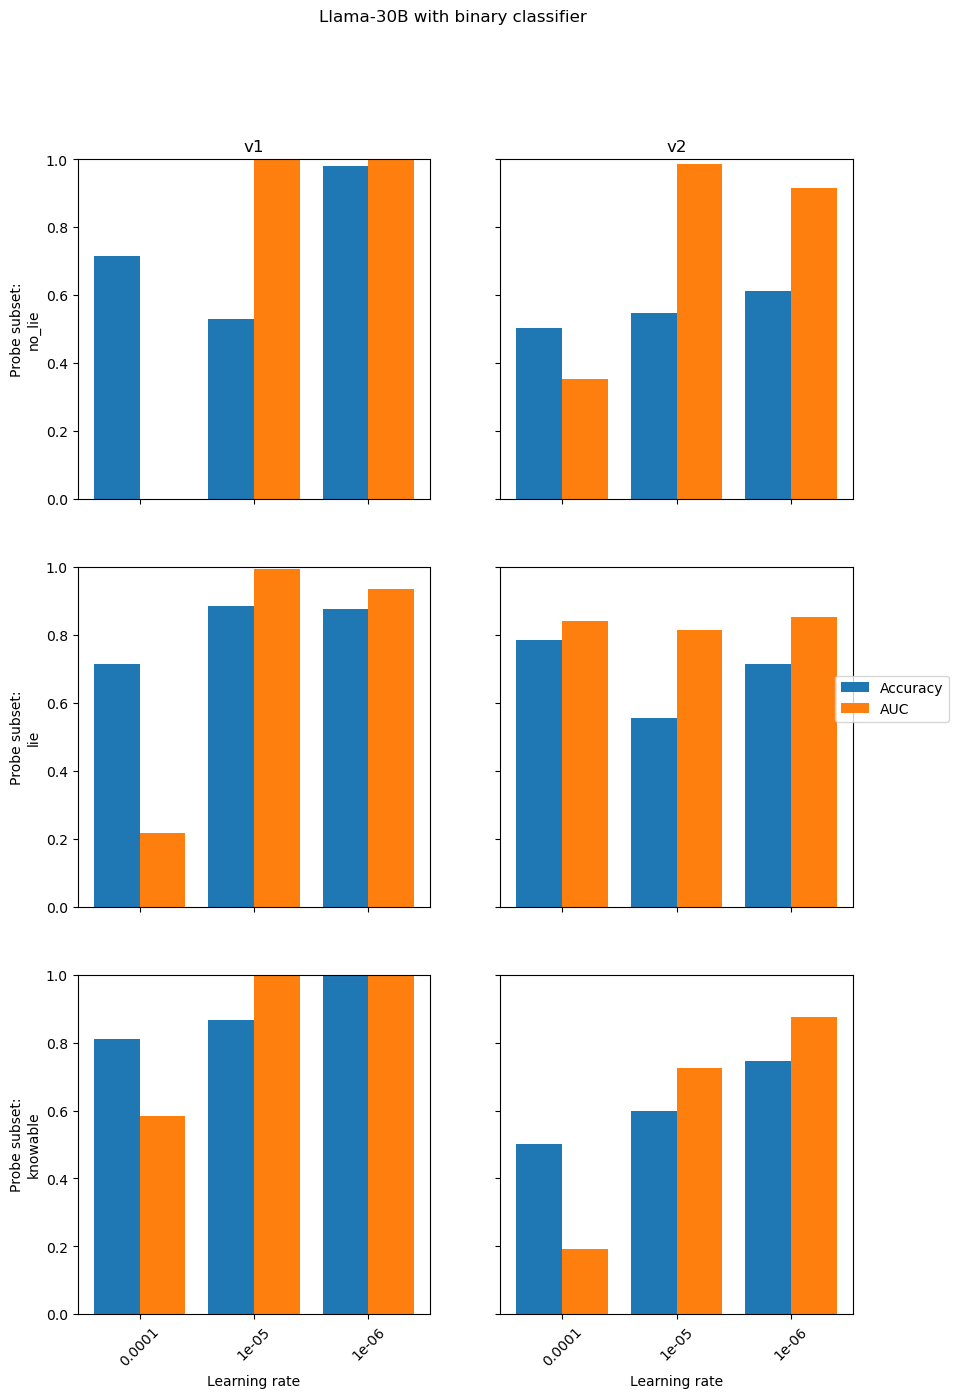

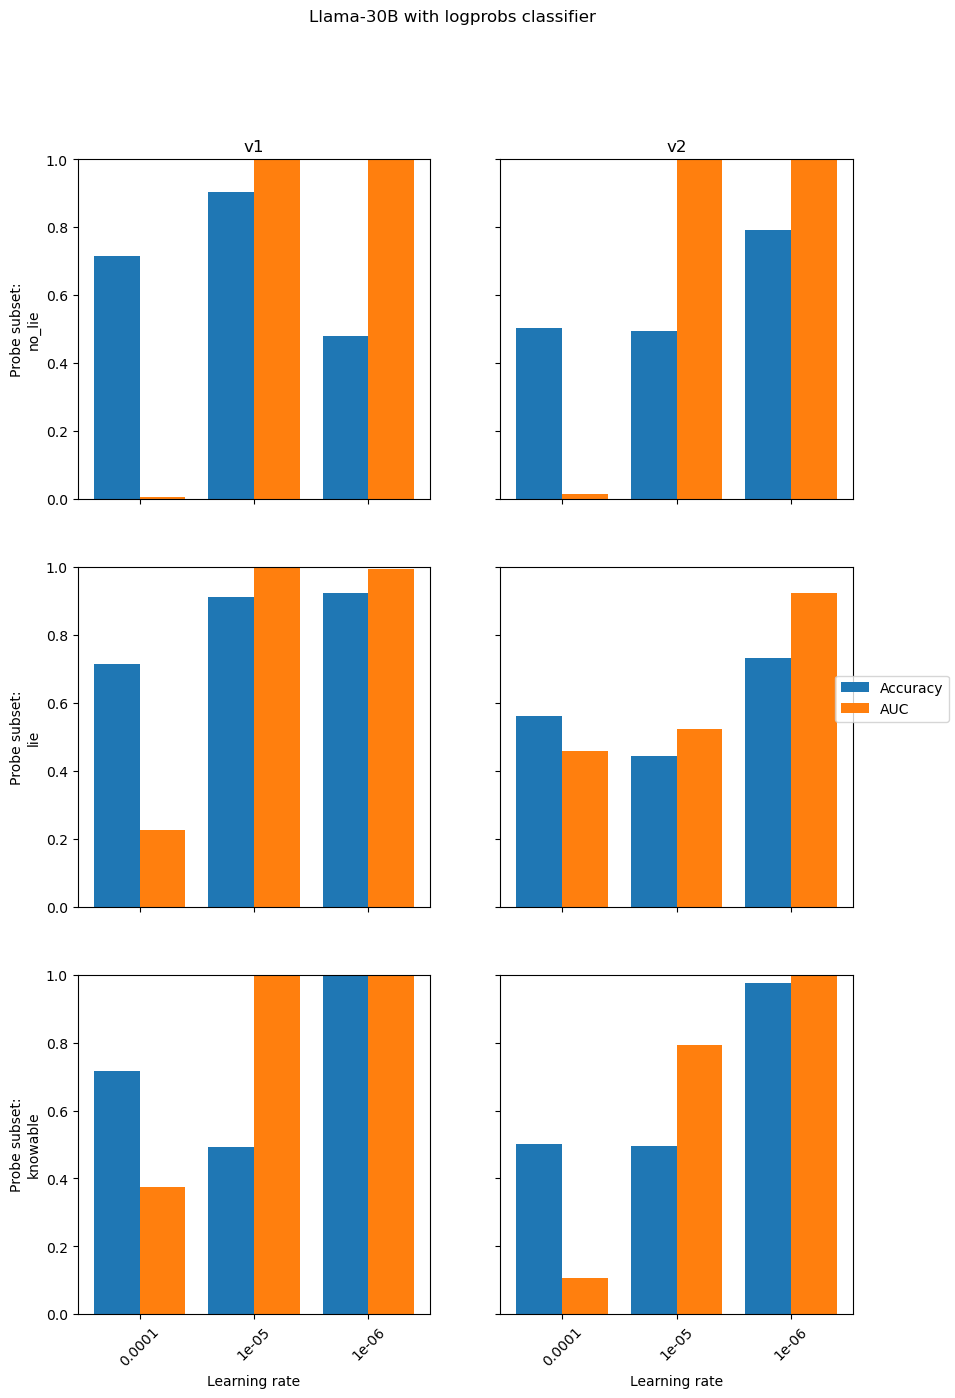

In [ ]:
model_size = "30B"
LRS=(0.0001, 1e-05, 1e-06)

# filter by model size
df_0 = classification_results_df[classification_results_df["model"].apply(lambda x: model_size in x)]

for binary in [True, False]:
    fig, axes = plt.subplots(3, 2, figsize=(10, 15), sharex="col", sharey="row")
    axes = axes.transpose()

    # only keep rows where binary is True or False
    df1 = df_0[df_0["binary"] == binary]

    for ax, version in zip(axes, FT_VERSIONS):
        # keep only rows with the right version
        df2 = df1[df1["model"].apply(lambda x: version in x)]
        for a, subset_name in zip(ax, name_list):
            # keep only those with the right subset:
            df3 = df2[df2["subset"] == subset_name]
            # offset the bar for accuracy to the left
            a.bar(pd.Series(LRS).apply(lambda x: f"{x}"), df3["accuracy"], width=-0.4, align="edge")
            # offset the bar for auc to the right
            a.bar(pd.Series(LRS).apply(lambda x: f"{x}"), df3["auc"], width=0.4, align="edge")
            a.set_ylim(0, 1)
            if version == "v1":
                a.set_ylabel("Probe subset:\n" + subset_name)

        # tilt x ticks
        ax[0].set_title(f"{version}")
        ax[2].set_xlabel("Learning rate")
        for tick in ax[2].get_xticklabels():
            tick.set_rotation(45)
    fig.suptitle(f"Llama-30B with {'binary' if binary else 'logprobs'} classifier")
    # put an external legend
    fig.legend(["Accuracy", "AUC"], loc="center right")
    plt.show()

In [ ]:
# only select 1e-05 and logprobs
df = classification_results_df_7b[classification_results_df_7b["model"].apply(lambda x: "v1" in x)]
df = df[df["binary"] == True]
df[["model", "binary", "subset", "accuracy", "auc"]]

,model,binary,subset,accuracy,auc
0,llama-7B-ft-v1-lr-0.001,True,no_lie,0.465517,0.362903
0,llama-7B-ft-v1-lr-0.001,True,lie,0.465517,0.596027
0,llama-7B-ft-v1-lr-0.001,True,knowable,0.465517,0.500000
0,llama-7B-ft-v1-lr-0.0001,True,no_lie,0.498282,0.000000
0,llama-7B-ft-v1-lr-0.0001,True,lie,0.498282,0.020406
0,llama-7B-ft-v1-lr-0.0001,True,knowable,0.498282,0.000142
0,llama-7B-ft-v1-lr-3e-05,True,no_lie,0.540892,0.197493
0,llama-7B-ft-v1-lr-3e-05,True,lie,0.500000,0.836390
0,llama-7B-ft-v1-lr-3e-05,True,knowable,0.488848,0.108359
0,llama-7B-ft-v1-lr-1e-05,True,no_lie,0.494354,0.097076


# JB added stuff

In [ ]:
## (JB) Get table that fits into the spreadsheet

df = classification_results_df_7b[classification_results_df_7b["model"].apply(lambda x: "v2" in x)]
df = df[df["binary"] == False]
# add learning rate column. format is "llama-7B-ft-v1-lr-3e-05"
df["lr"] = df["model"].apply(lambda x: float(x[x.index("lr-") + 3:]))
df = df.pivot(index="lr", columns="subset", values="auc")
# sort by descending lr
df = df.sort_index(ascending=False)
# sort columns in order "no_lie", "lie", "knowable"
df = df[["no_lie", "lie", "knowable"]]
# transpose
df = df.transpose()
df

lr,1.000000e-03,1.000000e-04,3.000000e-05,1.000000e-05,3.000000e-06,1.000000e-06,3.000000e-07,1.000000e-07
subset,,,,,,,,
no_lie,NaN,0.005877,0.999072,0.999859,0.999506,0.178723,0.519373,0.621876
lie,NaN,0.323992,0.025892,0.990316,0.867821,0.586225,0.427254,0.386320
knowable,NaN,0.328800,0.021148,0.993459,1.000000,0.882422,0.474637,0.688716


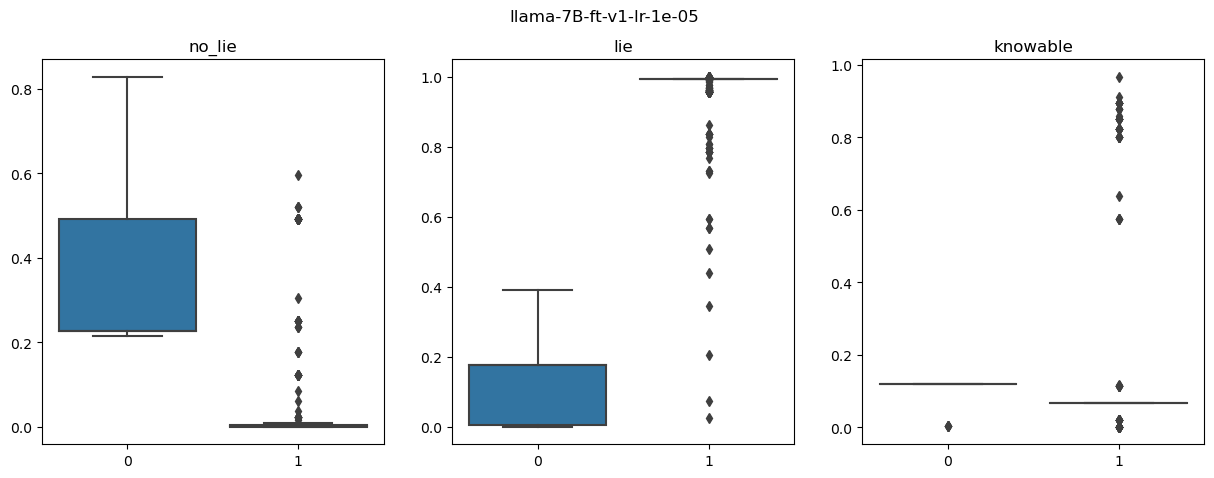

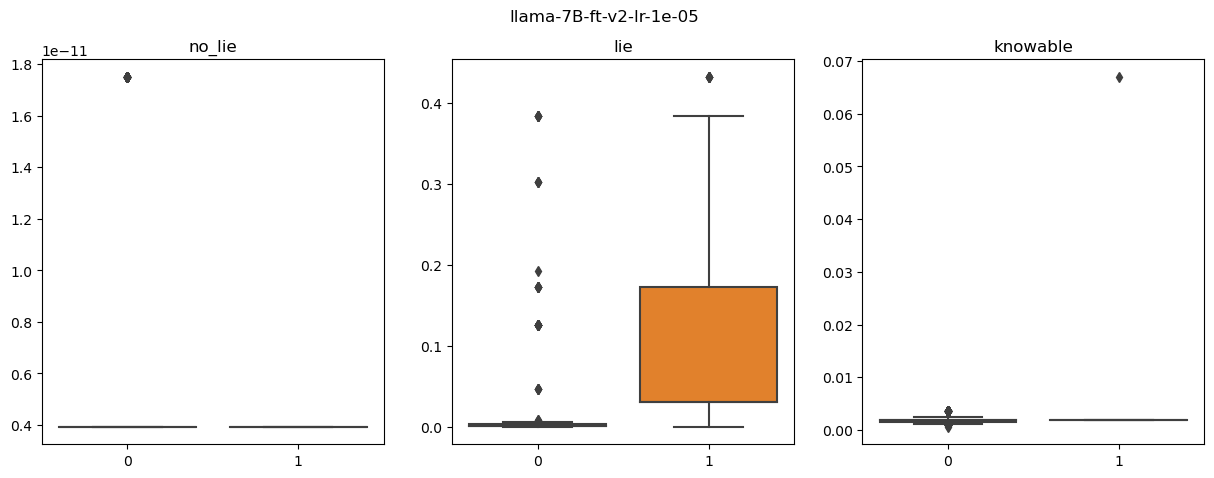

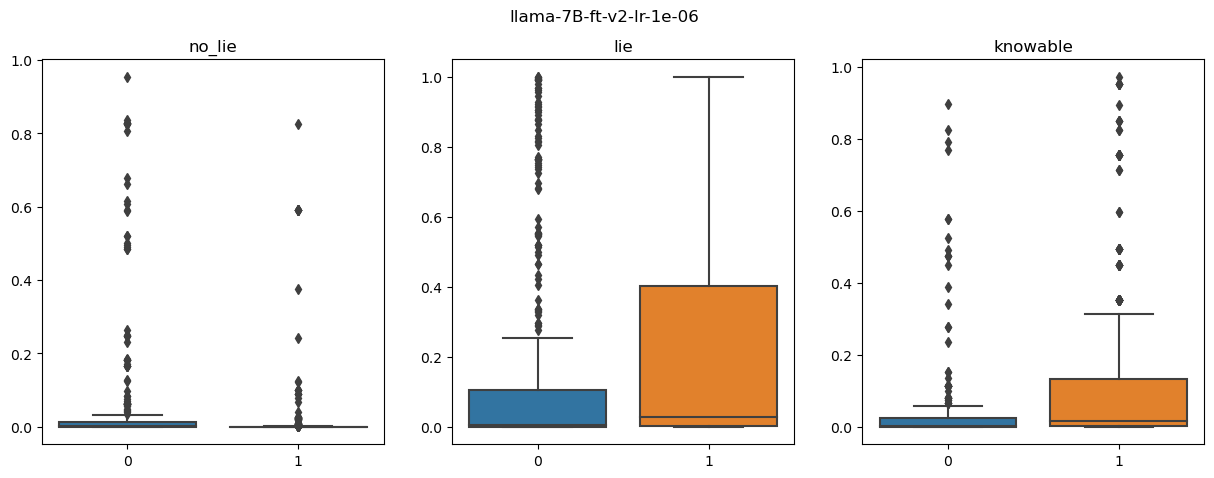

In [130]:
## the good 30B ones
# relevant_models = [
#     "llama-30B-ft-v1-lr-1e-05",
#     "llama-30B-ft-v1-lr-1e-06",
#     "llama-30B-ft-v2-lr-1e-05",
#     "llama-30B-ft-v2-lr-1e-06",
# ]
# df = classification_results_df_30b

# # the good 7B finetunes where the classifier works well
# relevant_models = [
#     "llama-7B-ft-v1-lr-3e-06",
#     "llama-7B-ft-v1-lr-1e-06",
#     "llama-7B-ft-v2-lr-3e-06",
# ]
# df = classification_results_df_7b

# the good 7B finetunes where the classifier doesn't work well
relevant_models = [
    "llama-7B-ft-v1-lr-1e-05",
    "llama-7B-ft-v2-lr-1e-05",
    "llama-7B-ft-v2-lr-1e-06",
]
df = classification_results_df_7b


for m in relevant_models:
    # figure with 3 subplots horizontally
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, ss in enumerate(["no_lie", "lie", "knowable"]):
        mask = (df["model"] == m) & (df["binary"] == True) & (df["subset"] == ss)
        temp = df[mask]
        preds_neg_class = temp.iloc[0]["y_pred_proba"][np.array(temp.iloc[0]["labels"]) == 0]
        preds_pos_class = temp.iloc[0]["y_pred_proba"][np.array(temp.iloc[0]["labels"]) == 1]
        sns.boxplot(data=[preds_neg_class, preds_pos_class], ax=axes[i])
        axes[i].set_title(ss)
    fig.suptitle(m)
    plt.show()

(455,)

In [114]:
subset



'knowable'

In [115]:
temp["subset"] == subset

0    False
0    False
0     True
Name: subset, dtype: bool

In [116]:
df

,model,accuracy,auc,y_pred,y_pred_proba,labels,binary,subset
0,llama-30B-ft-v1-lr-0.0001,0.715640,0.005188,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0003339685374554377, 0.000348562324905777, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,no_lie
0,llama-30B-ft-v1-lr-0.0001,0.715640,0.226932,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.041338618843422895, 0.04240483934474604, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,lie
0,llama-30B-ft-v1-lr-0.0001,0.715640,0.373841,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.013796368555421167, 0.013078510242290158, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,knowable
0,llama-30B-ft-v1-lr-1e-05,0.904529,1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.7734717476782645e-07, 1.3255471758842316e-0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,no_lie
0,llama-30B-ft-v1-lr-1e-05,0.910649,0.999155,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.001825314889067155, 0.026016338368920495, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,lie
0,llama-30B-ft-v1-lr-1e-05,0.493268,0.999089,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.005744310612107376, 0.0050056475655984685, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,knowable
0,llama-30B-ft-v1-lr-1e-06,0.479055,1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0001586403611242256, 0.00016242483504598067...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,no_lie
0,llama-30B-ft-v1-lr-1e-06,0.923738,0.995104,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.003641877457227199, 0.0059193222656465354, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,lie
0,llama-30B-ft-v1-lr-1e-06,1.000000,1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0007793687676206393, 0.0006236344035345638,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,knowable
0,llama-30B-ft-v2-lr-0.0001,0.502439,0.013802,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0001065800840612467, 6.402489425913653e-05,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,no_lie
